In [1]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt 

import torch

from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
import torch.nn.functional as TF
from torchlib.transforms import functional as F
from torchlib.datasets.fersynthetic  import SyntheticFaceDataset
from torchlib.datasets.factory  import FactoryDataset
from torchlib.datasets.datasets import Dataset

from aug import get_transforms_aug, get_transforms_det


In [2]:
!ls ../out/

affectnetdarck
attmap.png
att.png
att_snt.png
cratedataset.txt
exp_cb.mkv
experiments_cls.csv
experiments_recovery.csv
exp_mz_sn.avi
exp_mz_sn.mkv
feratt_atentionresnet34_attgmm_adam_affectdark_dim64_preactresnet18x32_fold0_000
feratt_atentionresnet34_attgmm_adam_affectnetdark_dim64_preactresnet18x32_fold0_000
feratt_atentionresnet34_attgmm_adam_bu3dfe_dim64_preactresnet18x32_fold0_000
feratt_atentionresnet34_attgmm_adam_bu3dfe_dim64_preactresnet18x64_fold0_000
feratt_atentionresnet34_attgmm_adam_ferblack_dim64_preactresnet18x32_fold0_000
image.png
result
srf.png


In [24]:
project          = '../out'
name             = 'feratt_atentionresnet34_attgmm_adam_affectnetdark_dim64_preactresnet18x32_fold0_000'
pathnamedataset  = '~/.datasets'
pathmodel        = os.path.join( project, name, 'models/model_best.pth.tar' ) #model_best, chk000120
pathproject      = os.path.join( project, name )
size_input=64
idenselect=np.arange(10)

namedataset_train = FactoryDataset.affect
namedataset_val = FactoryDataset.affect

data_train = Dataset(
    data=FactoryDataset.factory(
        pathname=pathnamedataset, 
        name=namedataset_train, 
        subset=FactoryDataset.validation, 
        idenselect=idenselect,
        download=False ),
    num_channels=3,
    transform=mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_CONSTANT ) 
    )

data_val = Dataset(
    data=FactoryDataset.factory(
        pathname=pathnamedataset, 
        name=namedataset_val, 
        subset=FactoryDataset.validation, # FactoryDataset.validation, training
        idenselect=idenselect,
        download=False ),
    num_channels=3,
    transform=mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_CONSTANT ) 
    )

print(len(data_train))
print(len(data_val))


4000
4000


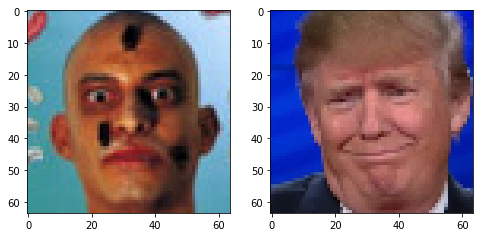

In [25]:

def recover(x, embs, n = 4):
    '''recover'''    
    i = np.argsort( ((embs - x) ** 2).sum(axis=1) )
    return i[:min(n,len(embs))]

def showsample( data, i=0 ):
    #img, label = data[ i ]
    sample = data[ i ]
    img, label = sample['image'], sample['label']
    #label=np.argmax(label)
    #classe = data.data.classes[label]
    img = np.array(img)
    plt.imshow( img )
    #plt.title('class: {}'.format(classe) )
    
    
i = np.random.randint( len(data_train) )
j = np.random.randint( len(data_val) )

plt.figure( figsize=(8,4))
plt.subplot(121)
showsample( data_train, i )
plt.subplot(122)
showsample( data_val, j )
plt.show()

In [26]:
reppathname_train = os.path.join( pathproject, 'rep_{}_{}_{}_{}.pth'.format(name, namedataset_train, 'train', 'real') )
reppathname_val   = os.path.join( pathproject, 'rep_{}_{}_{}_{}.pth'.format(name, namedataset_val, 'train', 'real') )

rep_data = torch.load(reppathname_train)
Z_train = rep_data['Z']
Y_train = rep_data['Y']

rep_data = torch.load(reppathname_val)
Z_val = rep_data['Z']
Y_val = rep_data['Y']
print(Z_train.shape)
print(Z_val.shape)

(287651, 64)
(287651, 64)


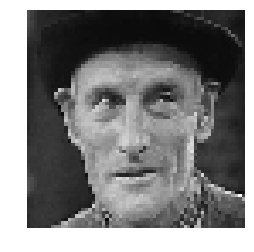

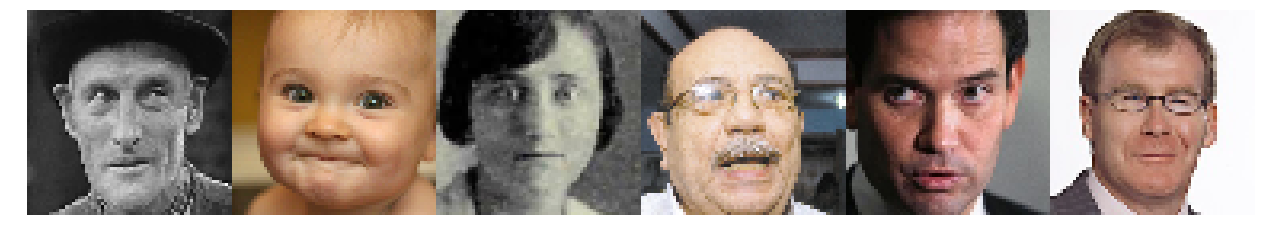

In [33]:
n=6
i = np.random.randint( len(Z_train) )
j = recover(Z_train[i,:], Z_val , n = n)

img_query = data_train[i]['image']
img_recover = [ data_val[j[i]]['image']  for i in range(n)  ]
img_recover = np.concatenate( img_recover, axis=1 )


plt.figure( figsize=(4,4) )
plt.imshow(img_query)
plt.axis('off')
plt.show()

plt.figure( figsize=(22,12) )
plt.imshow(img_recover)
plt.axis('off')
plt.show()


# plt.figure( figsize=(22,12) )
# plt.subplot(1,n+0,1) #+1
# plt.imshow(img_query)
# plt.axis('off')
# for i in range(n):
#     plt.subplot(1,n+0,i+1) #+1
#     plt.imshow( data_val[j[i]]['image'] )
#     plt.axis('off')
# plt.show()


In [74]:
from sklearn.manifold import TSNE

namedataset=FactoryDataset.celeba
subset='train'
real='real'

reppathname = os.path.join( pathproject, 'rep_{}_{}_{}_{}.pth'.format(name, namedataset, subset, real ) )
tsnpathname = os.path.join( pathproject, 'tsn_{}_{}_{}_{}.csv'.format(name, namedataset, subset, real ) )

rep_data = torch.load(reppathname)
Z = rep_data['Z']
Y = rep_data['Y']

Z = Z[:1000,:]
Y = Y[:1000] #

print('load data')
print('Z:', Z.shape)
print('Y:', Y.shape)

Zt = TSNE(n_components=2, init='pca', 
    random_state=0, perplexity=30).fit_transform(Z)

# save
ZY = np.concatenate((Zt,Y[:, np.newaxis]),axis=1)
df = pd.DataFrame( ZY )
df.to_csv( tsnpathname , index=False, encoding='utf-8')

print('tsne calculte done')

load data
Z: (1000, 64)
Y: (1000,)
tsne calculte done


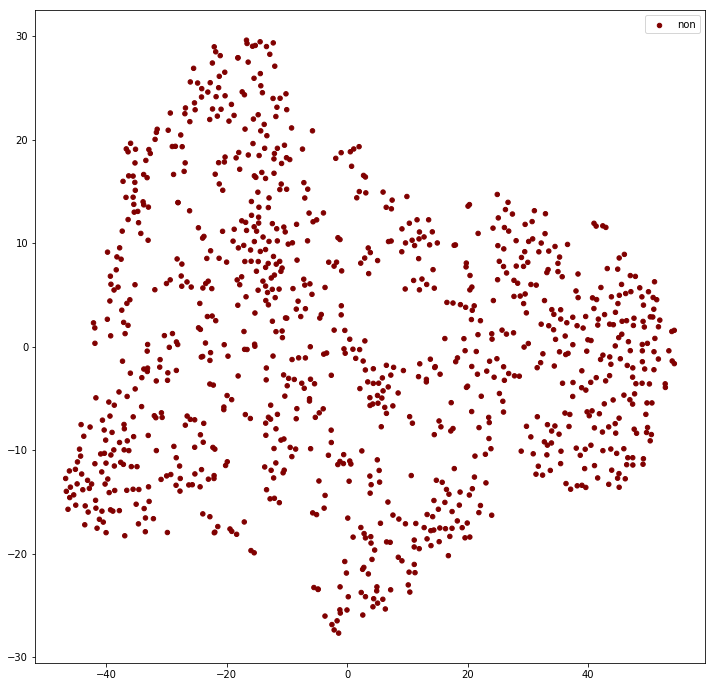

In [75]:
cmap = plt.get_cmap('jet_r')

#show
plt.figure( figsize=(12,12) )
#plt.scatter(Xt[:,0], Xt[:,1], s=(10,10), marker='o', c=Yo);
n = len(np.unique(Y))
for i in range( n ):
    index = Y==i
    color = cmap(float(i)/n) 
    plt.scatter(Zt[index,0], Zt[index,1], s=(20,20), marker='o', color=color, label='{}'.format( 'non' ) ); #dataloader.dataset.data.classes[i] )

plt.legend()
plt.savefig( os.path.join( pathproject, 'tsn_{}_{}_{}_{}.png'.format( name, namedataset, subset, real ) ) )
plt.show()
